![Melanoma Detection](https://www.yashodahealthcare.com/blogs/wp-content/uploads/2021/07/melanoma-skin-cancer.jpeg)

<cite>Image from www.yashodahealthcare.com </cite>

Problem statement: Experiment with a CNN-LSTM hybrid model that can do better in the detection of skin diseases and cancers that the existing CNN model using the same techniques provided.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
import os

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively. Beacuse this implementation will be completed in Google Colab, the Google Drive will be mounted in this notebook.

In [2]:
data_dir_train = pathlib.Path(os.getcwd() + "\Train")
print("data_dir_train: ", data_dir_train)
data_dir_test = pathlib.Path(os.getcwd() + "\Test")
print("data_dir_test: ", data_dir_test)

data_dir_train:  C:\Users\prama\OneDrive\Documents\VT_DellInsprion153000\Fall 2024\ECE5424\Midterm\Skin cancer ISIC The International Skin Imaging Collaboration\Train
data_dir_test:  C:\Users\prama\OneDrive\Documents\VT_DellInsprion153000\Fall 2024\ECE5424\Midterm\Skin cancer ISIC The International Skin Imaging Collaboration\Test


In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118




### Define some parameters for the loader:

Use 80% of the images for training, and 20% for validation.

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


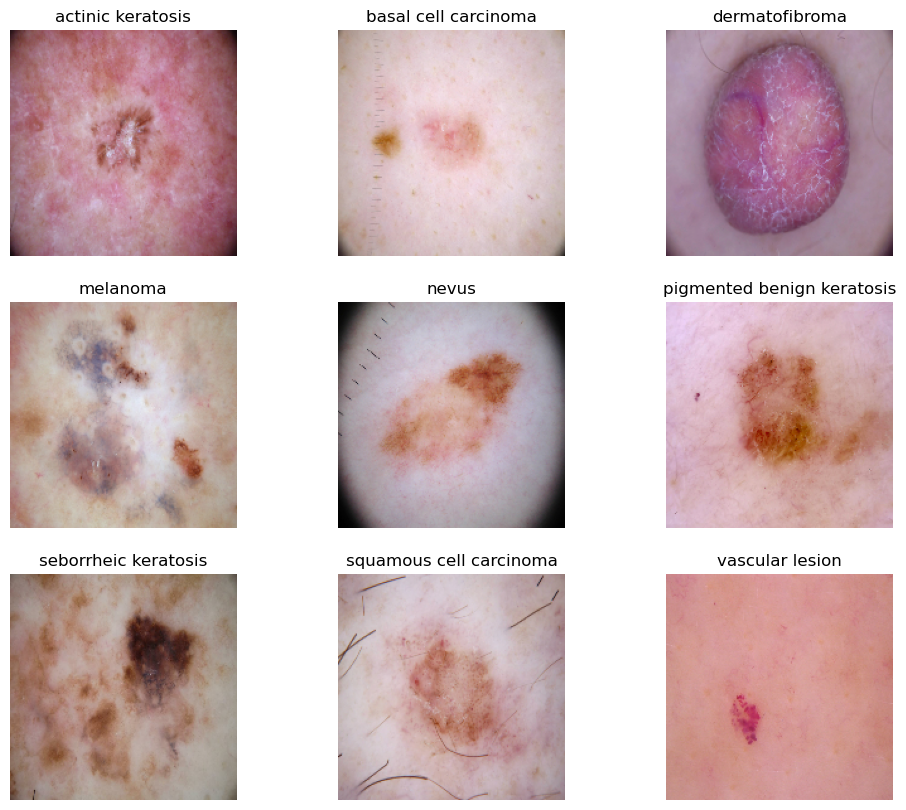

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
for i in range(len(class_names)):
  filtered_ds = train_ds.filter(lambda x,l:tf.math.equal(l[0], i))
  for image, label in filtered_ds.take(1):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

### Create the model
####  A CNN-LSTM model is created to detect 9 classes present in the dataset. ```layers.experimental.preprocessing.Rescaling``` is used to normalize pixel values between (0,1) before feeding into the neural network and clean up the data.

In [10]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  #layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Flatten(),  # Flatten after LSTM
  layers.Reshape((-1, 32)),  # Reshape to (timesteps, features) before LSTM
  layers.LSTM(32, return_sequences=True, activation = 'tanh'),
  layers.Dropout(0.2),
  layers.Flatten(),  # Flatten after LSTM
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
An appropirate optimiser and loss function for model training was chosen.

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 8100, 32)          0         
                                                                 
 lstm (LSTM)                 (None, 8100, 32)          8320      
                                                                 
 dropout (Dropout)           (None, 8100, 32)          0         
                                                        

### Train the model

In [13]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
56/56 [==============================] - 668s 12s/step - loss: 3.0762 - accuracy: 0.1908 - val_loss: 2.1845 - val_accuracy: 0.1924
Epoch 2/10
56/56 [==============================] - 747s 13s/step - loss: 2.1752 - accuracy: 0.1964 - val_loss: 2.1672 - val_accuracy: 0.1924
Epoch 3/10
56/56 [==============================] - 735s 13s/step - loss: 2.1574 - accuracy: 0.1964 - val_loss: 2.1500 - val_accuracy: 0.1924
Epoch 4/10
56/56 [==============================] - 734s 13s/step - loss: 2.1406 - accuracy: 0.1964 - val_loss: 2.1344 - val_accuracy: 0.1924
Epoch 5/10
56/56 [==============================] - 736s 13s/step - loss: 2.1253 - accuracy: 0.1964 - val_loss: 2.1204 - val_accuracy: 0.1924
Epoch 6/10
56/56 [==============================] - 735s 13s/step - loss: 2.1116 - accuracy: 0.1964 - val_loss: 2.1076 - val_accuracy: 0.1924
Epoch 7/10
56/56 [==============================] - 736s 13s/step - loss: 2.0993 - accuracy: 0.1964 - val_loss: 2.0965 - val_accuracy: 0.1924
Epoch 

### Visualizing training results

acc:  0.1964285671710968


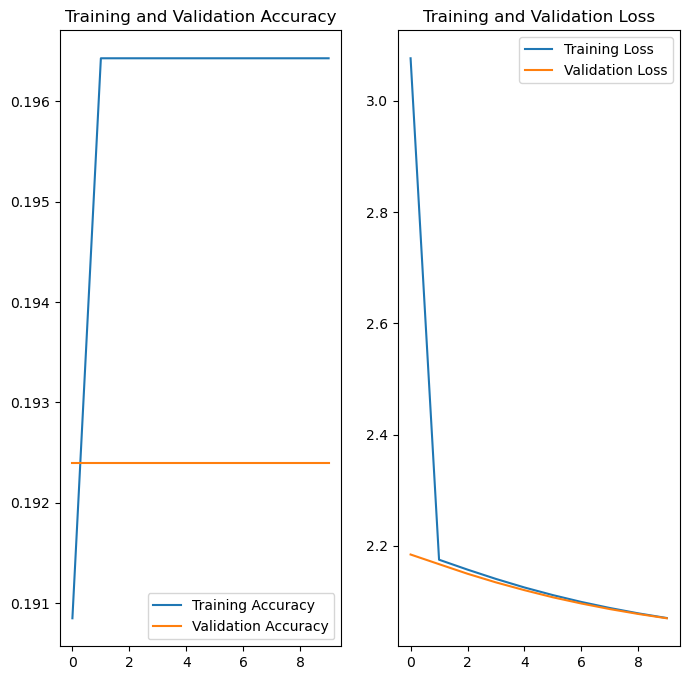

In [14]:
acc = history.history['accuracy']
print("acc: ", acc[len(acc) - 1])
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Findings:
1] We can clearly observe a drastic difference between Traning and Validation Accuracy, which indicates that the model has overfitted<br>
2] Also we can observe that the validation accuracy the model has achieved is below 55 % <br>
Overall we need to apply techniques like <b>Data Augmentation and Dropout</b> to handle the overfitting issue of the model

### Data Augmentation

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

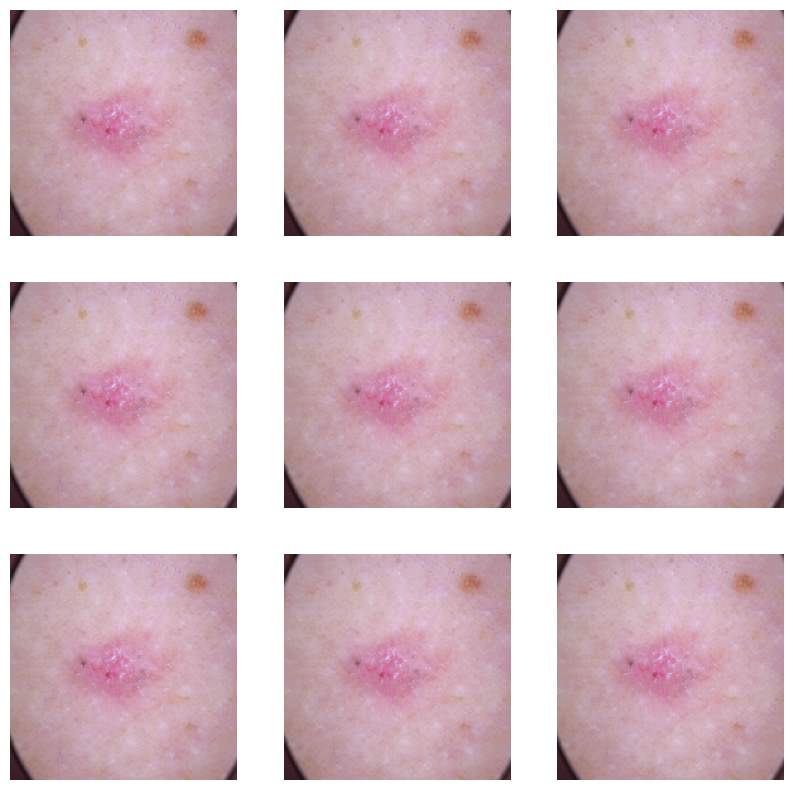

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [17]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  #layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Dropout(0.2),

  layers.Reshape((-1, 32)),  # Reshape to (timesteps, features) before LSTM
  layers.LSTM(32, return_sequences=True, activation = 'tanh'),
  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [19]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
56/56 [==============================] - 774s 14s/step - loss: 4.6090 - accuracy: 0.1546 - val_loss: 2.1942 - val_accuracy: 0.1902
Epoch 2/10
56/56 [==============================] - 779s 14s/step - loss: 2.1722 - accuracy: 0.1948 - val_loss: 2.1642 - val_accuracy: 0.1902
Epoch 3/10
56/56 [==============================] - 776s 14s/step - loss: 2.1543 - accuracy: 0.1959 - val_loss: 2.1480 - val_accuracy: 0.1924
Epoch 4/10
56/56 [==============================] - 795s 14s/step - loss: 2.1394 - accuracy: 0.1964 - val_loss: 2.1320 - val_accuracy: 0.1924
Epoch 5/10
56/56 [==============================] - 793s 14s/step - loss: 2.1243 - accuracy: 0.1964 - val_loss: 2.1173 - val_accuracy: 0.1924
Epoch 6/10
56/56 [==============================] - 787s 14s/step - loss: 2.1105 - accuracy: 0.1964 - val_loss: 2.1053 - val_accuracy: 0.1924
Epoch 7/10
56/56 [==============================] - 783s 14s/step - loss: 2.0984 - accuracy: 0.1964 - val_loss: 2.0940 - val_accuracy: 0.1924
Epoch 

### Visualizing the results

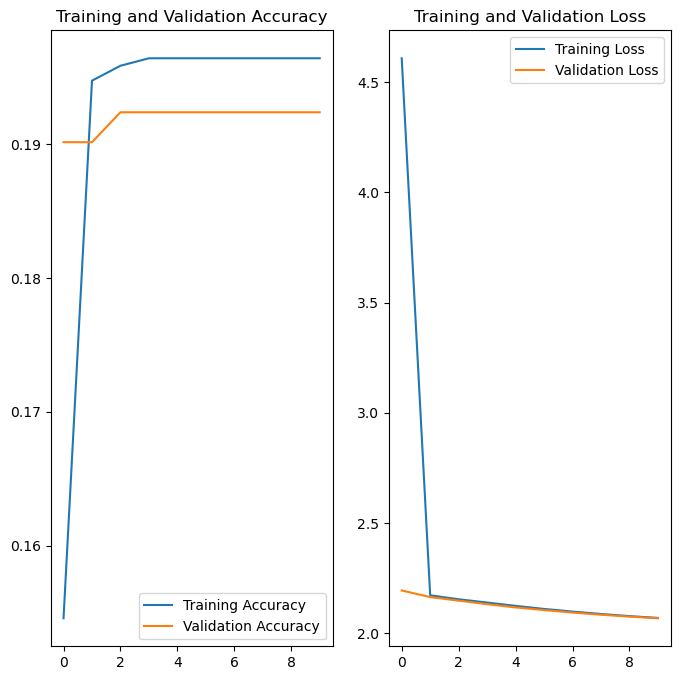

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:
As we can see that now the Training and Validation accuracy are almost in the same level and the highest accuracy achieved is around 60% , this shows the impact of how performing Data Augmentation can improve the model performance<br>
But we can still try to increase the accuracy of the model

## Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [21]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
df

,Path,Label
0,C:\Users\prama\OneDrive\Documents\VT_DellInspr...,actinic keratosis
1,C:\Users\prama\OneDrive\Documents\VT_DellInspr...,actinic keratosis
2,C:\Users\prama\OneDrive\Documents\VT_DellInspr...,actinic keratosis
3,C:\Users\prama\OneDrive\Documents\VT_DellInspr...,actinic keratosis
4,C:\Users\prama\OneDrive\Documents\VT_DellInspr...,actinic keratosis
...,...,...
2234,C:\Users\prama\OneDrive\Documents\VT_DellInspr...,vascular lesion
2235,C:\Users\prama\OneDrive\Documents\VT_DellInspr...,vascular lesion
2236,C:\Users\prama\OneDrive\Documents\VT_DellInspr...,vascular lesion
2237,C:\Users\prama\OneDrive\Documents\VT_DellInspr...,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


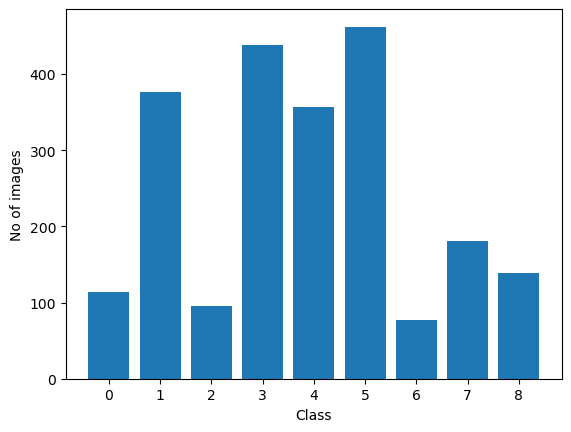

In [22]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

X, y = df['Path'], df['Label']
y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.xticks([i for i in range(9)])
plt.xlabel("Class")
plt.ylabel("No of images")
plt.show()

## Write your findings here:
#### - Which class has the least number of samples?
<b>Ans]</b> From the above bar chart we can see that the class with label 6 has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
<b>Ans]</b> We can observe that of all the class, class with label 5 has the most number of samples

##Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [24]:
path_to_training_dataset = data_dir_train
import Augmentor
for i in class_names:
#     print(str(path_to_training_dataset) + "/" + i)
    p = Augmentor.Pipeline(str(path_to_training_dataset) + "/" + i, output_directory = '/kaggle/working/' + i +'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:/kaggle/working/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B3A9FAFE08>: 100%|█| 500/500 [00:06<00:00, 78.12 Samples/


Initialised with 376 image(s) found.
Output directory set to C:/kaggle/working/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B39FF20C48>: 100%|█| 500/500 [00:06<00:00, 72.61 Samples/


Initialised with 95 image(s) found.
Output directory set to C:/kaggle/working/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B39FF39CC8>: 100%|█| 500/500 [00:06<00:00, 74.34 Samples/


Initialised with 438 image(s) found.
Output directory set to C:/kaggle/working/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x1B3ACB741C8>: 100%|█| 500/500 [00:39<00:00, 12.63 Samples/


Initialised with 357 image(s) found.
Output directory set to C:/kaggle/working/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x1B39FB32C48>: 100%|█| 500/500 [00:33<00:00, 15.09 Sample


Initialised with 462 image(s) found.
Output directory set to C:/kaggle/working/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B39FB89D08>: 100%|█| 500/500 [00:07<00:00, 67.92 Samples/


Initialised with 77 image(s) found.
Output directory set to C:/kaggle/working/seborrheic keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1B39FF347C8>:  55%|▌| 276/500 [00:11<00


AttributeError: 'OSError' object has no attribute 'message'

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
output_dir = pathlib.Path('/kaggle/working/')

In [ ]:
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(output_dir, '*','output', '*.jpg'))]
path_list[:5]

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(output_dir, '*','output', '*.jpg'))]
lesion_list_new[:5]

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df.append(df2)

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Train the model on the data created using Augmentor

## Create a training dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

## Create your model (make sure to include normalization)

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  #layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Dropout(0.2),

  layers.Reshape((-1, 32)),  # Reshape to (timesteps, features) before LSTM
  layers.LSTM(32, return_sequences=True, activation = 'tanh'),
  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

## Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train your model

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
print(f"acc: {acc[len(acc) - 1]}")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



## Findings:
We can infer that the Model is fit with a good enough accuracy for both Train and Validation Data of max accuracy around 85%
Rectifying the Class Imbalance and performing Data augumentation on the dataset has resulted in a model with higher accuracy and overcoming overfitting
This is a good model to be used to predict Skin Cancer using CNN